In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
base_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
df = pd.read_csv(base_path + 'mrp_final_dataset.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['majority_label'])  # Maps labels to integers

In [ ]:
df['label'].value_counts()

,count
label,
1,3584
0,2879


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import random
import os

In [ ]:
train_eval_df, final_test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_eval_df, test_size=0.1, random_state=42, stratify=train_eval_df['label'])

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

def prepare_data(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

X_train = prepare_data(train_df['text'], tokenizer)
X_val = prepare_data(val_df['text'], tokenizer)
X_test = prepare_data(final_test_df['text'], tokenizer)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = final_test_df['label'].values

# Hyperparameter Tuning for CNN-BiLSTM Model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

In [ ]:
def build_cnn_bilstm_model(vocab_size=20000, embed_dim=100, filters=128, kernel_size=5,
                           lstm_units=128, dropout_rate=0.5):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=X_train.shape[1]),
        Conv1D(filters, kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
def train_and_evaluate(model_fn, name, save=False):
    model = model_fn()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    preds_prob = model.predict(X_test)
    preds = (preds_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f"\n{name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=2))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    if save:
        model.save(f"{name}.h5")

    return acc, f1

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5805 - loss: 0.6667 - val_accuracy: 0.6983 - val_loss: 0.6057
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7849 - loss: 0.4541 - val_accuracy: 0.7099 - val_loss: 0.6647
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9027 - loss: 0.2472 - val_accuracy: 0.7118 - val_loss: 0.8920
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9599 - loss: 0.1202 - val_accuracy: 0.7137 - val_loss: 1.1555
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9834 - loss: 0.0550 - val_accuracy: 0.7253 - val_loss: 1.3920
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

CNN_BiLSTM_ed100_f64_lstm128_do0.3 - Accuracy: 0.7216, F1 Score: 0.7692

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       576
           1       0.71      0.84      0.77       717

    accuracy                           0.72      1293
   macro avg   

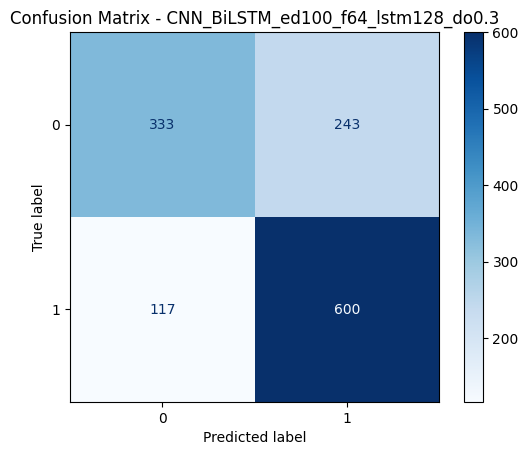

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5918 - loss: 0.6686 - val_accuracy: 0.7099 - val_loss: 0.5976
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7816 - loss: 0.4705 - val_accuracy: 0.7079 - val_loss: 0.6403
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8973 - loss: 0.2542 - val_accuracy: 0.6963 - val_loss: 0.8569
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9542 - loss: 0.1264 - val_accuracy: 0.7060 - val_loss: 1.1175
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9774 - loss: 0.0630 - val_accuracy: 0.7234 - val_loss: 1.3029
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

CNN_BiLSTM_ed100_f64_lstm128_do0.5 - Accuracy: 0.7053, F1 Score: 0.7596

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       576
           1       0.69      0.84      0.76       717

    accuracy                           0.71      1293
   macro avg    

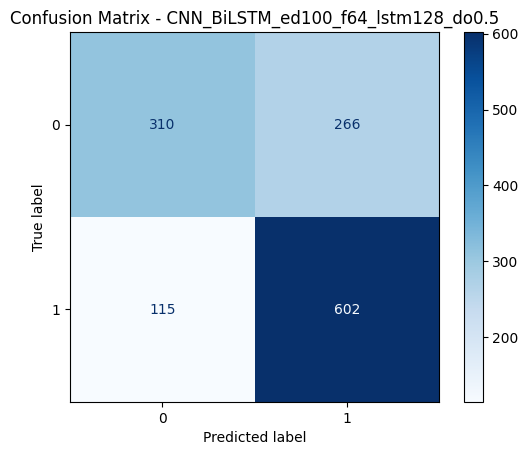

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5737 - loss: 0.6681 - val_accuracy: 0.6886 - val_loss: 0.6293
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7669 - loss: 0.4972 - val_accuracy: 0.6963 - val_loss: 0.6622
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8887 - loss: 0.2757 - val_accuracy: 0.7273 - val_loss: 0.9369
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9494 - loss: 0.1394 - val_accuracy: 0.7176 - val_loss: 1.0824
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9776 - loss: 0.0660 - val_accuracy: 0.7157 - val_loss: 1.2129
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed100_f64_lstm256_do0.3 - Accuracy: 0.7100, F1 Score: 0.7592

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       576
           1       0.70      0.82      0.76       717

    accuracy                           0.71      1293
   macro avg   

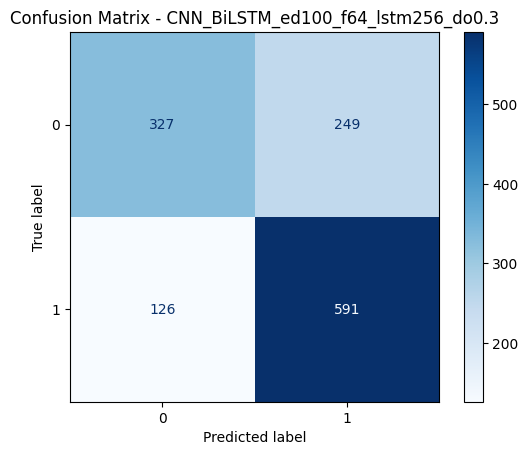

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5830 - loss: 0.6688 - val_accuracy: 0.6886 - val_loss: 0.6153
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7836 - loss: 0.4747 - val_accuracy: 0.7079 - val_loss: 0.6997
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8876 - loss: 0.2784 - val_accuracy: 0.7060 - val_loss: 0.9498
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9455 - loss: 0.1431 - val_accuracy: 0.6983 - val_loss: 1.0930
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9758 - loss: 0.0673 - val_accuracy: 0.7137 - val_loss: 1.3447
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

CNN_BiLSTM_ed100_f64_lstm256_do0.5 - Accuracy: 0.7224, F1 Score: 0.7658

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       576
           1       0.72      0.82      0.77       717

    accuracy                           0.72      1293
   macro avg    

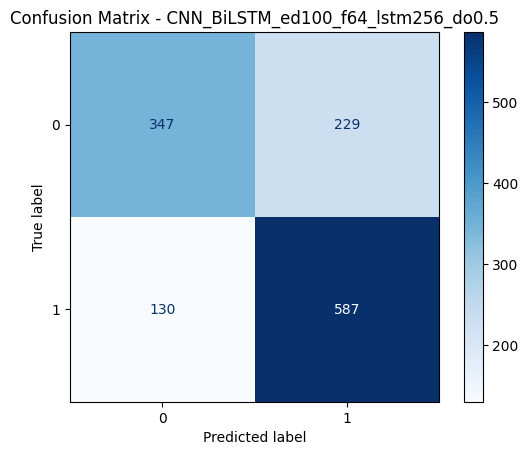

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5917 - loss: 0.6631 - val_accuracy: 0.6963 - val_loss: 0.5965
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7951 - loss: 0.4422 - val_accuracy: 0.7234 - val_loss: 0.6610
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9077 - loss: 0.2370 - val_accuracy: 0.6925 - val_loss: 0.9290
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9589 - loss: 0.1164 - val_accuracy: 0.7118 - val_loss: 1.0994
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9785 - loss: 0.0674 - val_accuracy: 0.7137 - val_loss: 1.2190
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed100_f128_lstm128_do0.3 - Accuracy: 0.7015, F1 Score: 0.7655

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       576
           1       0.68      0.88      0.77       717

    accuracy                           0.70      1293
   macro avg  

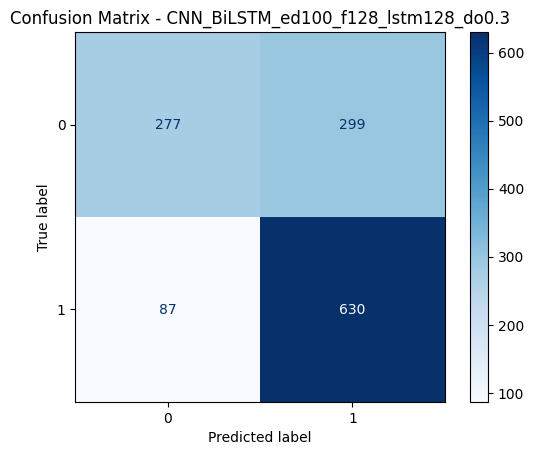

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5800 - loss: 0.6659 - val_accuracy: 0.6770 - val_loss: 0.6099
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7703 - loss: 0.4866 - val_accuracy: 0.7060 - val_loss: 0.6560
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8948 - loss: 0.2706 - val_accuracy: 0.7002 - val_loss: 0.9866
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9482 - loss: 0.1485 - val_accuracy: 0.7099 - val_loss: 0.9987
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9729 - loss: 0.0799 - val_accuracy: 0.7157 - val_loss: 1.2424
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

CNN_BiLSTM_ed100_f128_lstm128_do0.5 - Accuracy: 0.7108, F1 Score: 0.7689

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.52      0.61       576
           1       0.69      0.87      0.77       717

    accuracy                           0.71      1293
   macro avg  

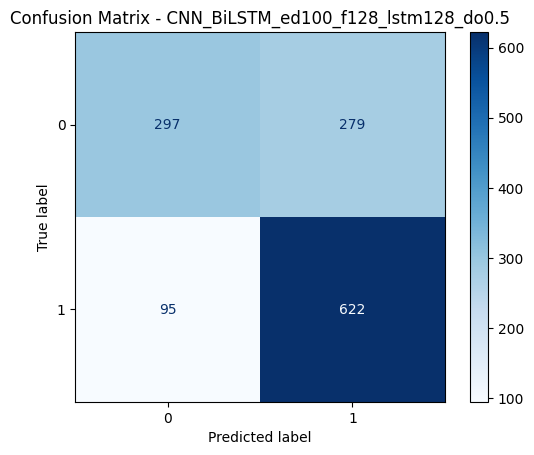

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5836 - loss: 0.6658 - val_accuracy: 0.6867 - val_loss: 0.6143
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7777 - loss: 0.4822 - val_accuracy: 0.7195 - val_loss: 0.6890
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8922 - loss: 0.2733 - val_accuracy: 0.7157 - val_loss: 0.8381
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9499 - loss: 0.1403 - val_accuracy: 0.6712 - val_loss: 0.9520
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9713 - loss: 0.0843 - val_accuracy: 0.7079 - val_loss: 1.1426
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed100_f128_lstm256_do0.3 - Accuracy: 0.7146, F1 Score: 0.7743

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.51      0.61       576
           1       0.69      0.88      0.77       717

    accuracy                           0.71      1293
   

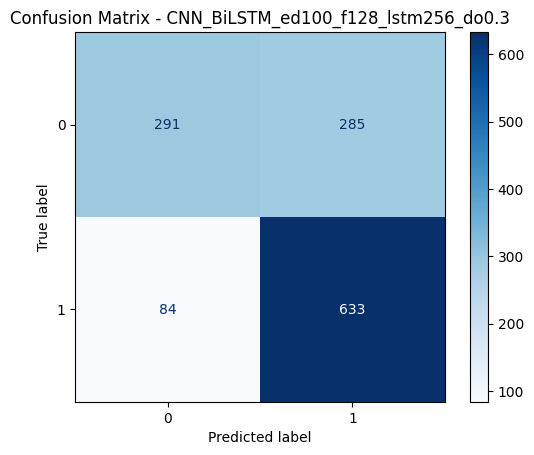

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5842 - loss: 0.6657 - val_accuracy: 0.7041 - val_loss: 0.6083
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7712 - loss: 0.4707 - val_accuracy: 0.7292 - val_loss: 0.6432
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9006 - loss: 0.2570 - val_accuracy: 0.7060 - val_loss: 0.9099
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9556 - loss: 0.1263 - val_accuracy: 0.6886 - val_loss: 1.1323
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9751 - loss: 0.0739 - val_accuracy: 0.7099 - val_loss: 1.2938
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed100_f128_lstm256_do0.5 - Accuracy: 0.7146, F1 Score: 0.7624

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64       576
           1       0.71      0.83      0.76       717

    accuracy                           0.71      1293
   macro avg  

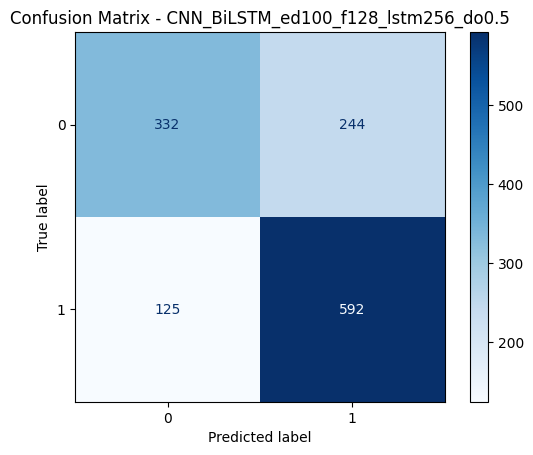

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5936 - loss: 0.6647 - val_accuracy: 0.7041 - val_loss: 0.5939
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7942 - loss: 0.4551 - val_accuracy: 0.7060 - val_loss: 0.6803
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9059 - loss: 0.2391 - val_accuracy: 0.7099 - val_loss: 1.0369
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9580 - loss: 0.1078 - val_accuracy: 0.7215 - val_loss: 1.0882
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9789 - loss: 0.0545 - val_accuracy: 0.7118 - val_loss: 1.2778
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed200_f64_lstm128_do0.3 - Accuracy: 0.7038, F1 Score: 0.7599

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.61       576
           1       0.69      0.85      0.76       717

    accuracy                           0.70      1293
   macro avg   

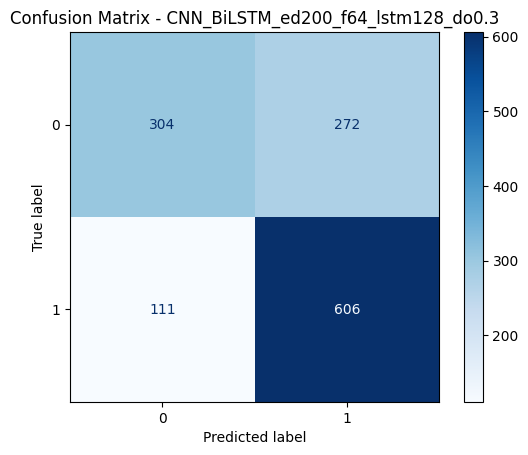

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5805 - loss: 0.6677 - val_accuracy: 0.7021 - val_loss: 0.5998
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7849 - loss: 0.4589 - val_accuracy: 0.7234 - val_loss: 0.6865
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9005 - loss: 0.2460 - val_accuracy: 0.7079 - val_loss: 0.9232
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9563 - loss: 0.1213 - val_accuracy: 0.7292 - val_loss: 1.2967
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9840 - loss: 0.0529 - val_accuracy: 0.7079 - val_loss: 1.2547
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

CNN_BiLSTM_ed200_f64_lstm128_do0.5 - Accuracy: 0.7278, F1 Score: 0.7589

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       576
           1       0.75      0.77      0.76       717

    accuracy                           0.73      1293
   macro avg    

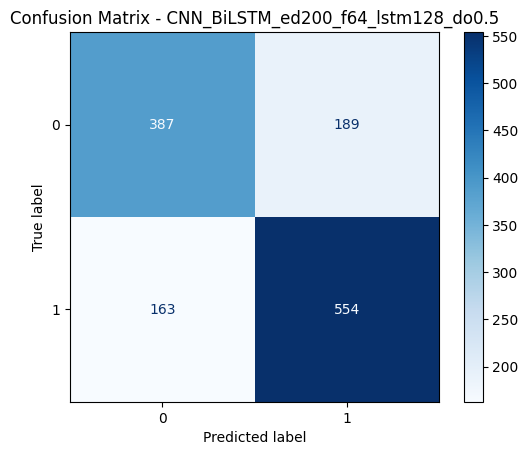

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5855 - loss: 0.6654 - val_accuracy: 0.7079 - val_loss: 0.5955
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7827 - loss: 0.4598 - val_accuracy: 0.6983 - val_loss: 0.6976
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9056 - loss: 0.2370 - val_accuracy: 0.6983 - val_loss: 0.9499
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9545 - loss: 0.1207 - val_accuracy: 0.6963 - val_loss: 1.1269
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9823 - loss: 0.0528 - val_accuracy: 0.7099 - val_loss: 1.3469
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

CNN_BiLSTM_ed200_f64_lstm256_do0.3 - Accuracy: 0.7224, F1 Score: 0.7791

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.52      0.63       576
           1       0.70      0.88      0.78       717

    accuracy                           0.72      1293
   macro avg   

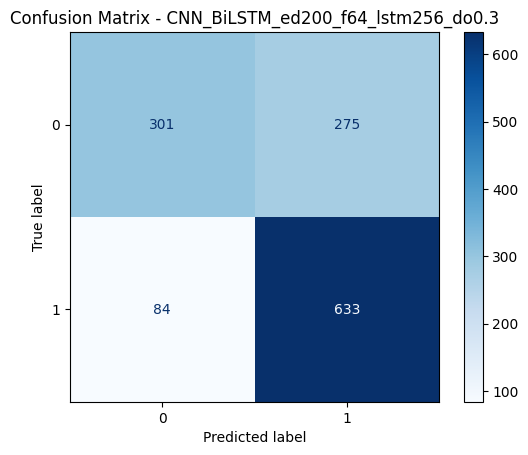

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5858 - loss: 0.6675 - val_accuracy: 0.7118 - val_loss: 0.6054
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7656 - loss: 0.4716 - val_accuracy: 0.7176 - val_loss: 0.6801
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8993 - loss: 0.2451 - val_accuracy: 0.6789 - val_loss: 0.8581
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9548 - loss: 0.1170 - val_accuracy: 0.6867 - val_loss: 1.0292
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9829 - loss: 0.0510 - val_accuracy: 0.7273 - val_loss: 1.1463
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

CNN_BiLSTM_ed200_f64_lstm256_do0.5 - Accuracy: 0.7193, F1 Score: 0.7575

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       576
           1       0.73      0.79      0.76       717

    accuracy                           0.72      1293
   macro avg  

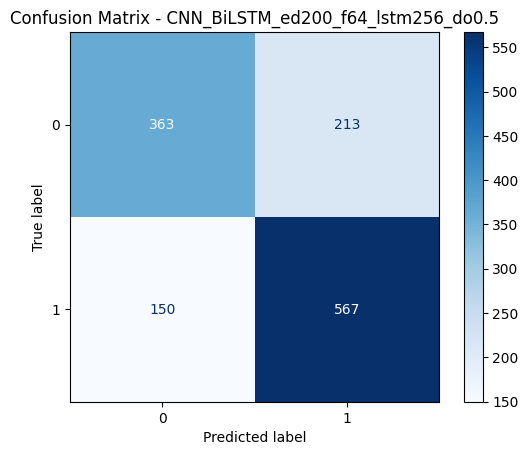

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.5955 - loss: 0.6567 - val_accuracy: 0.7002 - val_loss: 0.5966
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8028 - loss: 0.4247 - val_accuracy: 0.7118 - val_loss: 0.6787
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9123 - loss: 0.2499 - val_accuracy: 0.7099 - val_loss: 0.9427
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9611 - loss: 0.1095 - val_accuracy: 0.7137 - val_loss: 1.1153
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9799 - loss: 0.0481 - val_accuracy: 0.7060 - val_loss: 1.2685
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

CNN_BiLSTM_ed200_f128_lstm128_do0.3 - Accuracy: 0.7216, F1 Score: 0.7659

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       576
           1       0.72      0.82      0.77       717

    accuracy                           0.72      1293
   macro avg  

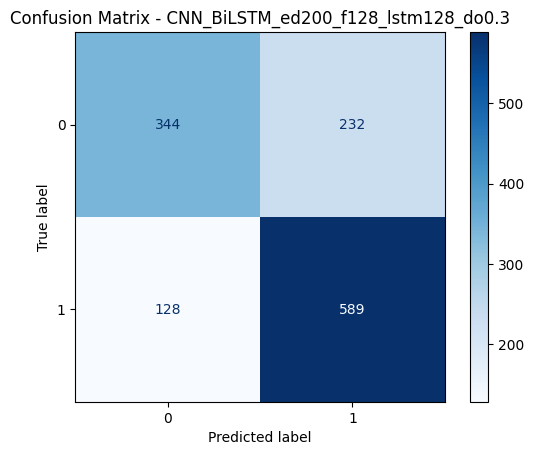

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6018 - loss: 0.6583 - val_accuracy: 0.7079 - val_loss: 0.5958
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7825 - loss: 0.4644 - val_accuracy: 0.7060 - val_loss: 0.7058
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9074 - loss: 0.2424 - val_accuracy: 0.7079 - val_loss: 1.0194
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9606 - loss: 0.1104 - val_accuracy: 0.6615 - val_loss: 1.1161
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9738 - loss: 0.0702 - val_accuracy: 0.7099 - val_loss: 1.3739
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

CNN_BiLSTM_ed200_f128_lstm128_do0.5 - Accuracy: 0.7108, F1 Score: 0.7543

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       576
           1       0.71      0.80      0.75       717

    accuracy                           0.71      1293
   macro avg  

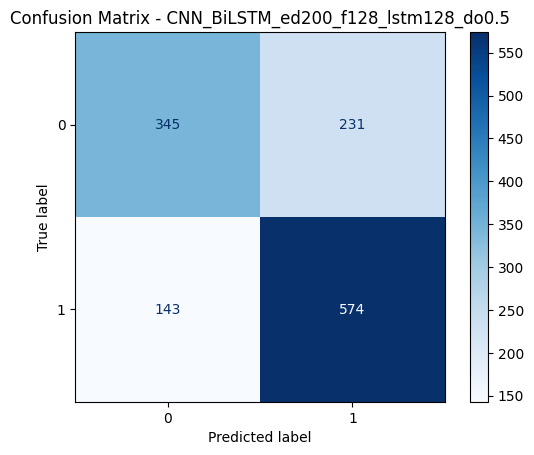

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6045 - loss: 0.6599 - val_accuracy: 0.7060 - val_loss: 0.6031
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7977 - loss: 0.4373 - val_accuracy: 0.6925 - val_loss: 0.6851
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9174 - loss: 0.2231 - val_accuracy: 0.7060 - val_loss: 0.9134
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9609 - loss: 0.1105 - val_accuracy: 0.6925 - val_loss: 1.1145
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9859 - loss: 0.0410 - val_accuracy: 0.6963 - val_loss: 1.4568
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

CNN_BiLSTM_ed200_f128_lstm256_do0.3 - Accuracy: 0.7138, F1 Score: 0.7591

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       576
           1       0.71      0.81      0.76       717

    accuracy                           0.71      1293
   macro avg  

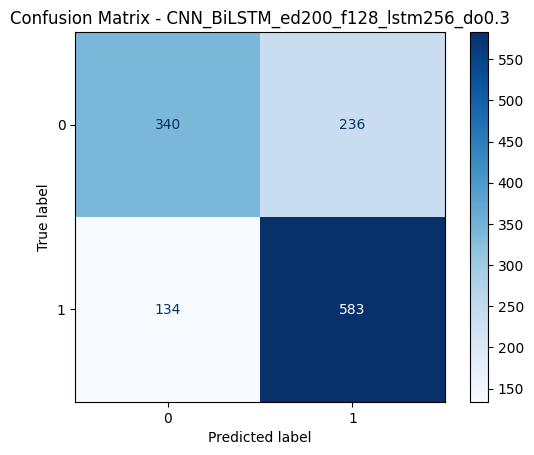

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5935 - loss: 0.6615 - val_accuracy: 0.6983 - val_loss: 0.6049
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7862 - loss: 0.4736 - val_accuracy: 0.7118 - val_loss: 0.6656
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8980 - loss: 0.2588 - val_accuracy: 0.7253 - val_loss: 0.9608
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9574 - loss: 0.1218 - val_accuracy: 0.7060 - val_loss: 1.0897
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9839 - loss: 0.0543 - val_accuracy: 0.6963 - val_loss: 1.3988
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

CNN_BiLSTM_ed200_f128_lstm256_do0.5 - Accuracy: 0.7146, F1 Score: 0.7657

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       576
           1       0.70      0.84      0.77       717

    accuracy                           0.71      1293
   macro avg  

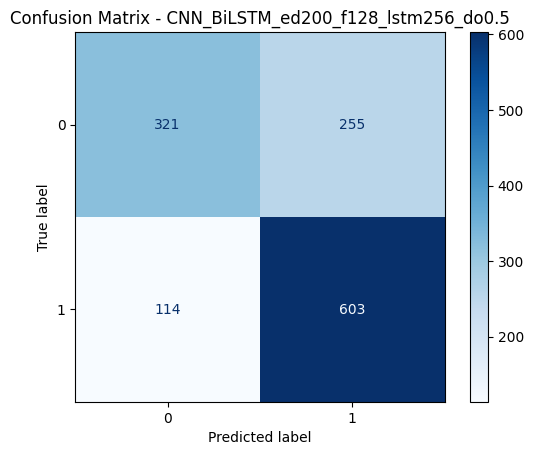

In [ ]:
# Hyperparameter grid
embed_dims = [100, 200]
filters_list = [64, 128]
lstm_units_list = [128, 256]
dropouts = [0.3, 0.5]

grid = list(itertools.product(embed_dims, filters_list, lstm_units_list, dropouts))
results = []

for embed_dim, filters, lstm_units, dropout_rate in grid:
    def model_fn():
        return build_cnn_bilstm_model(
            vocab_size=20000,
            embed_dim=embed_dim,
            filters=filters,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )
    name = f"CNN_BiLSTM_ed{embed_dim}_f{filters}_lstm{lstm_units}_do{dropout_rate}"
    acc, f1 = train_and_evaluate(model_fn, name)
    results.append((name, acc, f1))


In [ ]:
# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])

# Sort by F1 score (descending)
results_df = results_df.sort_values(by="F1 Score", ascending=False)

# Save to CSV
results_df.to_csv("cnn_bilstm_tuning_results.csv", index=False)

print("\nResults saved to cnn_bilstm_tuning_results.csv")
print(results_df)


Results saved to cnn_bilstm_tuning_results.csv
                                  Model  Accuracy  F1 Score
10   CNN_BiLSTM_ed200_f64_lstm256_do0.3  0.722351  0.779077
6   CNN_BiLSTM_ed100_f128_lstm256_do0.3  0.714617  0.774312
0    CNN_BiLSTM_ed100_f64_lstm128_do0.3  0.721578  0.769231
5   CNN_BiLSTM_ed100_f128_lstm128_do0.5  0.710750  0.768850
12  CNN_BiLSTM_ed200_f128_lstm128_do0.3  0.721578  0.765930
3    CNN_BiLSTM_ed100_f64_lstm256_do0.5  0.722351  0.765819
15  CNN_BiLSTM_ed200_f128_lstm256_do0.5  0.714617  0.765714
4   CNN_BiLSTM_ed100_f128_lstm128_do0.3  0.701469  0.765492
7   CNN_BiLSTM_ed100_f128_lstm256_do0.5  0.714617  0.762395
8    CNN_BiLSTM_ed200_f64_lstm128_do0.3  0.703790  0.759875
1    CNN_BiLSTM_ed100_f64_lstm128_do0.5  0.705336  0.759621
2    CNN_BiLSTM_ed100_f64_lstm256_do0.3  0.709977  0.759152
14  CNN_BiLSTM_ed200_f128_lstm256_do0.3  0.713844  0.759115
9    CNN_BiLSTM_ed200_f64_lstm128_do0.5  0.727765  0.758904
11   CNN_BiLSTM_ed200_f64_lstm256_do0.5  0.719258  0

/tmp/ipython-input-433001411.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


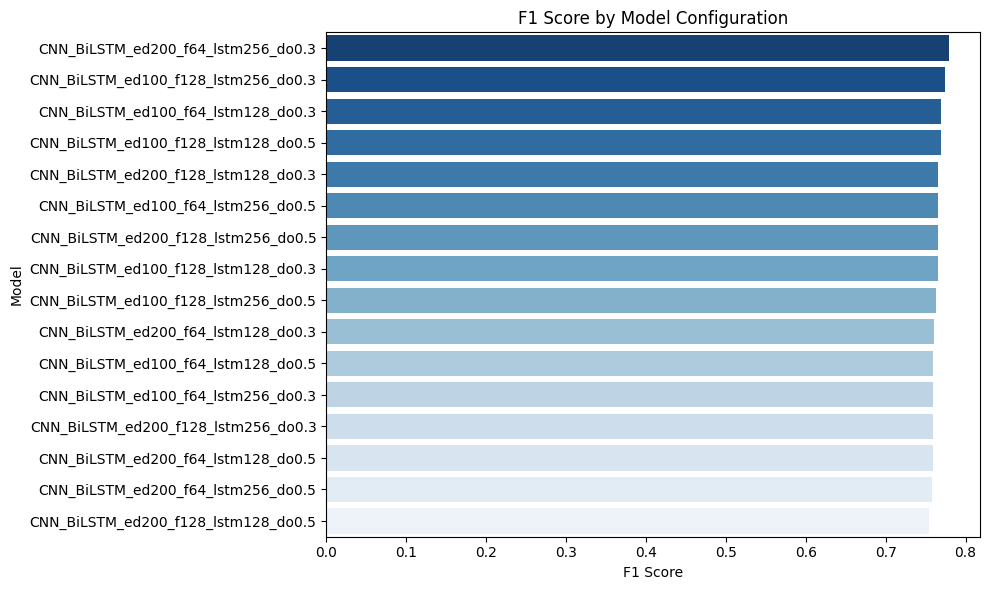

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results_df' is your DataFrame with "Model" and "F1 Score"
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="F1 Score",
    y="Model",
    palette="Blues_r"
)
plt.title("F1 Score by Model Configuration")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
